### In this notebook one fit logistic regression built on Pytorch on the raw event stream and on HOTS outputs

In [13]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%cd '../HOTS'

/home/antoine/homhots/HOTS/HOTS


In [14]:
from Tools import tic,toc, get_loader, fit_data, predict_data, classification_results
record_path = '../Records/EXP_03_NMNIST/models/'

# Network parameters

In [15]:
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
tau = 5
nblay = 3
nbclust = 4
filt = 2
timestr = '2021-02-16'

In [16]:
nb_test = 10000
nb_train = 60000
ds = 1200
nb_test = nb_test//ds
nb_train = nb_train//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

training set size: 50 - testing set: 8


# LR Parameters

In [17]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
#num_epochs = 2 ** 9 + 1
num_epochs

33

# Loading raw input as a dataset

In [18]:
name = 'raw'
learn_set, nb_pola, name_net = get_loader(name, record_path, nb_train, True, filt, tau, nblay, nbclust, sigma, homeinv, jitter, timestr)

# Fitting LR on the raw inputs

In [20]:
tic()
model, loss = fit_data(name_net, learn_set, nb_train,nb_pola,learning_rate,num_epochs,betas,verbose=True)
toc()

loading existing model
Done in 0.012 s


# Testing on the raw inputs


In [21]:
test_set, nb_pola, name_net = get_loader(name, record_path, nb_test, False, filt, tau, nblay, nbclust, sigma, homeinv, jitter, timestr)

In [22]:
pred_target, true_target = predict_data(test_set, model, nb_test)

np.mean(accuracy)=0.508


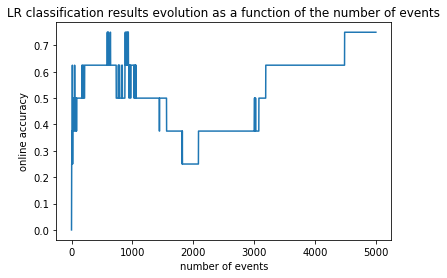

In [23]:
mean_acc, online_acc = classification_results(pred_target, true_target, nb_test, verbose= True)

# LR on the outputs of HOTS

In [24]:
name = 'homhots'
learn_set, nb_pola, name_net = get_loader(name, record_path, nb_train, True, filt, tau, nblay, nbclust, sigma, homeinv, jitter, timestr)

tic()
model, loss = fit_data(name_net, learn_set, nb_train, nb_pola, learning_rate, num_epochs, betas, verbose=True)
toc()

../Records/EXP_03_NMNIST/train/2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False_50_[None, None].pkl
2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False
loading existing model
Done in 0.002 s


../Records/EXP_03_NMNIST/test/2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False_8_[None, None].pkl
2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False
np.mean(accuracy)=0.822


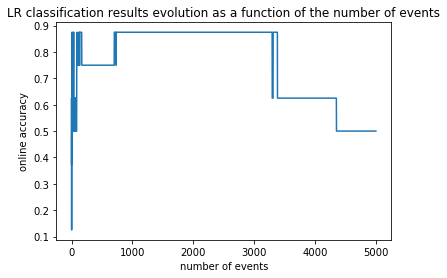

In [25]:
test_set, nb_pola, name_net = get_loader(name, record_path, nb_test, False, filt, tau, nblay, nbclust, sigma, homeinv, jitter, timestr)
pred_target, true_target = predict_data(test_set, model, nb_test)
mean_acc, online_acc = classification_results(pred_target, true_target, nb_test, verbose=True)